In [23]:
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [3]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch Version: {torch.__version__}")

Is CUDA available: False
PyTorch Version: 1.10.0+cpu


In [4]:
dataset_path = os.path.abspath("dataset")

transforms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ImageFolder(os.path.join(dataset_path, "Train"), transforms)
test_dataset = ImageFolder(os.path.join(dataset_path, "Test"), transforms)
validation_dataset = ImageFolder(os.path.join(dataset_path, "Validation"), transforms)

In [5]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, num_workers=0)

In [79]:
label_map = {0: "mask", 1: "no_mask"}

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)

        for (image, label, axs) in zip(images, labels, axs.flatten()):
            axs.imshow(image.permute(1,2,0).clamp(0,1))
            axs.set_title(label_map[label.item()])
            axs.axis('off')
        
        break

    plt.show()

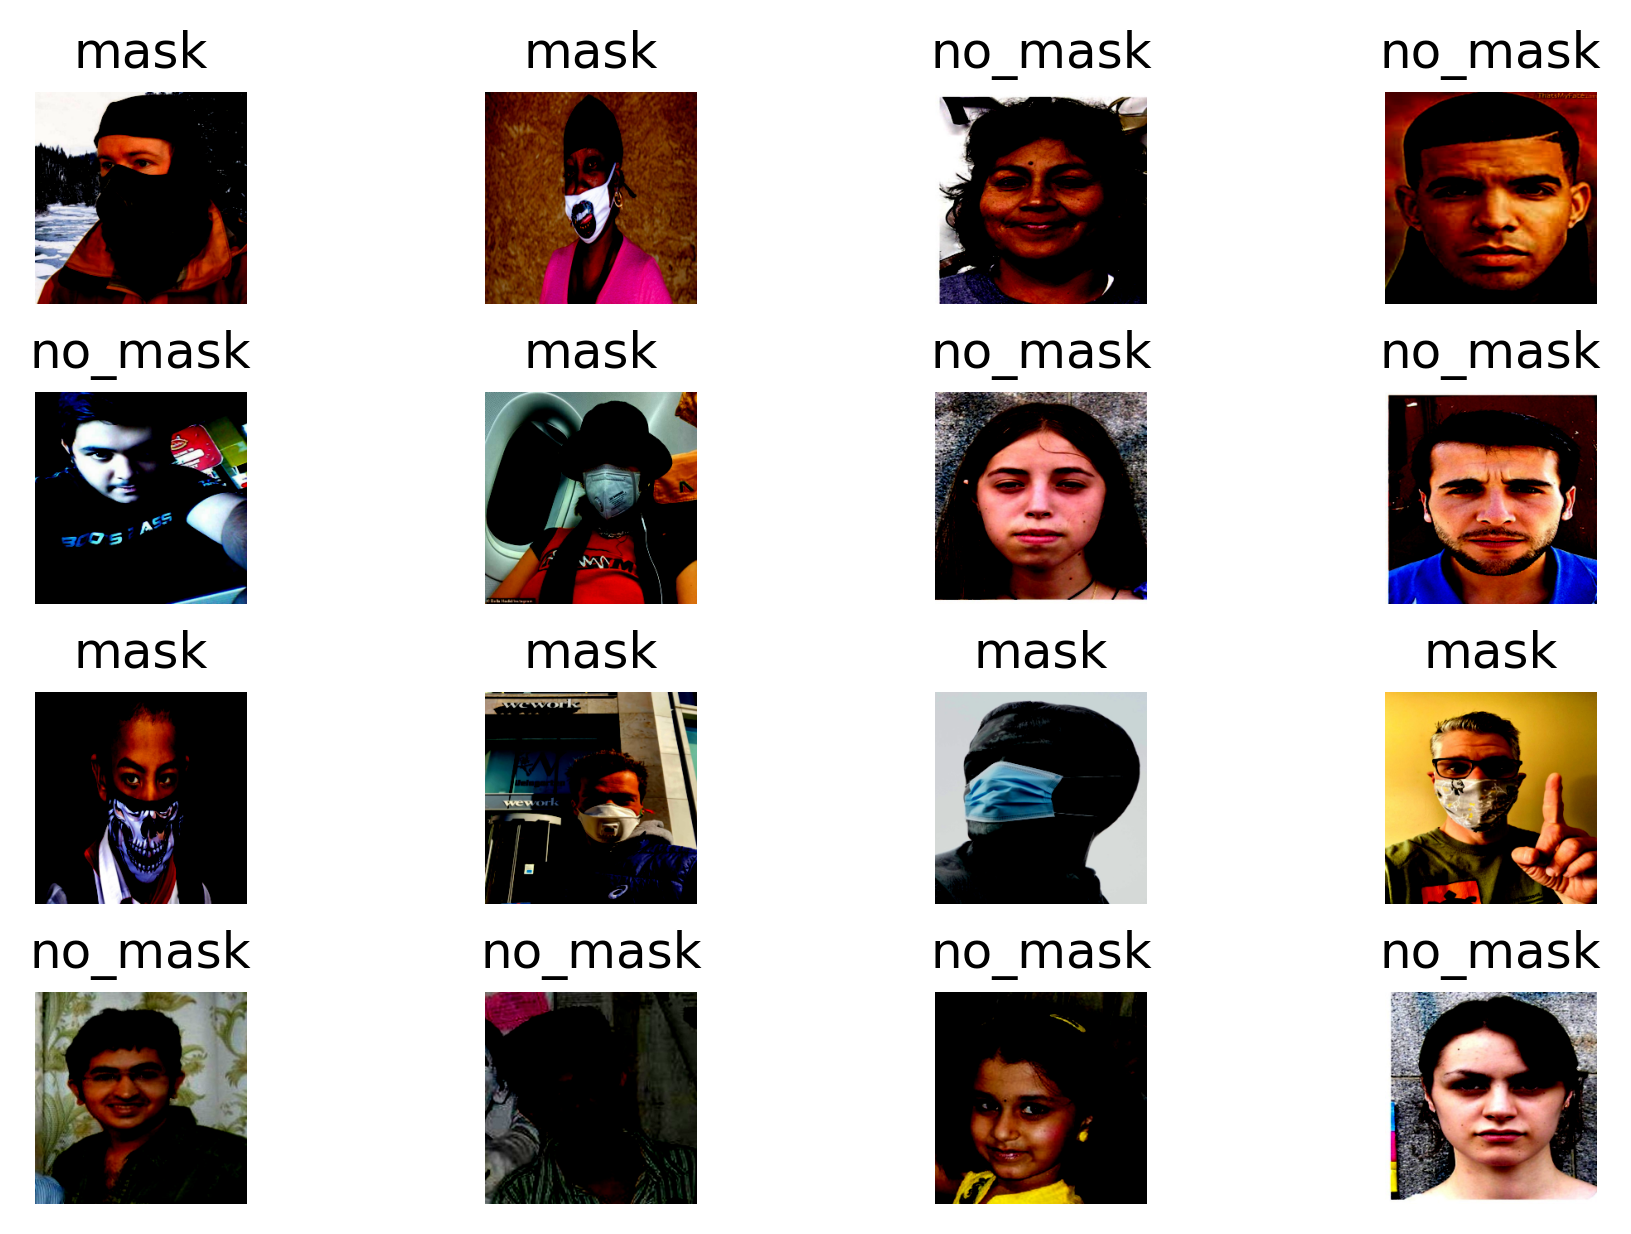

In [80]:
show_batch(train_dataloader)

In [8]:
for images, labels in test_dataloader:
    print(f"Shape of images [N, C, H, W]: {images.shape}")
    print(f"Shape of labels: {labels.shape}, {labels.dtype}")
    break

Shape of images [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of labels: torch.Size([16]), torch.int64


In [9]:
class CNN_net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_net, self).__init__()

        # input: 3 X 256 x 256
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(4)) # out: 16 x 64 x 64

        self.conv2 = nn.Sequential(nn.Conv2d(16, 64, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(8)) # out: 128 x 8 x 8

        self.res1 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True)) # out: 128 x 8 x 8

        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool2d(8)) # out: 128 x 1 x 1

        self.classifier = nn.Sequential(nn.Flatten(),  # out: 128
                                        nn.Linear(128, num_classes))  # out: 2

    def forward(self, inpt):
        out = self.conv1(inpt)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:
model = CNN_net(in_channels=3, num_classes=2).to(device)
print(model)

CNN_net(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [228]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [229]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [230]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [231]:
epochs = 50

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 0.001281  [    0/  600]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.239860 

Epoch 2
-------------------------------
loss: 0.019395  [    0/  600]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.273886 

Epoch 3
-------------------------------
loss: 0.035570  [    0/  600]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.123781 

Epoch 4
-------------------------------
loss: 0.041505  [    0/  600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.115920 

Epoch 5
-------------------------------
loss: 0.013836  [    0/  600]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.183956 

Epoch 6
-------------------------------
loss: 0.001736  [    0/  600]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.161278 

Epoch 7
-------------------------------
loss: 0.006197  [    0/  600]
Test Error: 
 Accuracy: 91.0%, Avg loss: 0.091822 

Epoch 8
-------------------------------
loss: 0.014453  [    0/  600]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.117726 

Epoch 9
----------------

In [232]:
# torch.save(model.state_dict(), "model.pth")
# print("Saved CNN_net model state to model.pth")

Saved CNN_net model state to model.pth


In [15]:
model = CNN_net(in_channels=3, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

In [17]:
def predict(tensor, model):
    prediction = model(tensor.unsqueeze(0))
    prediction = prediction.clone().detach()
    return prediction

In [81]:
classes = ["mask", "no_mask"]

model.eval()

rand_number = random.randint(0, len(validation_dataset))
x, y = validation_dataset[rand_number][0], validation_dataset[rand_number][1]

with torch.no_grad():
    pred = predict(x, model)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: \"{predicted}\", Actual: \"{actual}\"")

Predicted: "no_mask", Actual: "mask"


In [100]:
classes = ["mask", "no_mask"]

def show_validation(images, labels):
    fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)
    
    for (image, label, axs) in zip(images, labels, axs.flatten()):
        axs.imshow(image.permute(1,2,0).clamp(0,1))
        
        with torch.no_grad():
            pred = predict(image, model)
            predicted, actual = classes[pred[0].argmax(0)], classes[label]
            axs.set_title(f"net:{predicted},\nirl: {actual}", fontsize=10)
        
        axs.axis('off')

    plt.show()

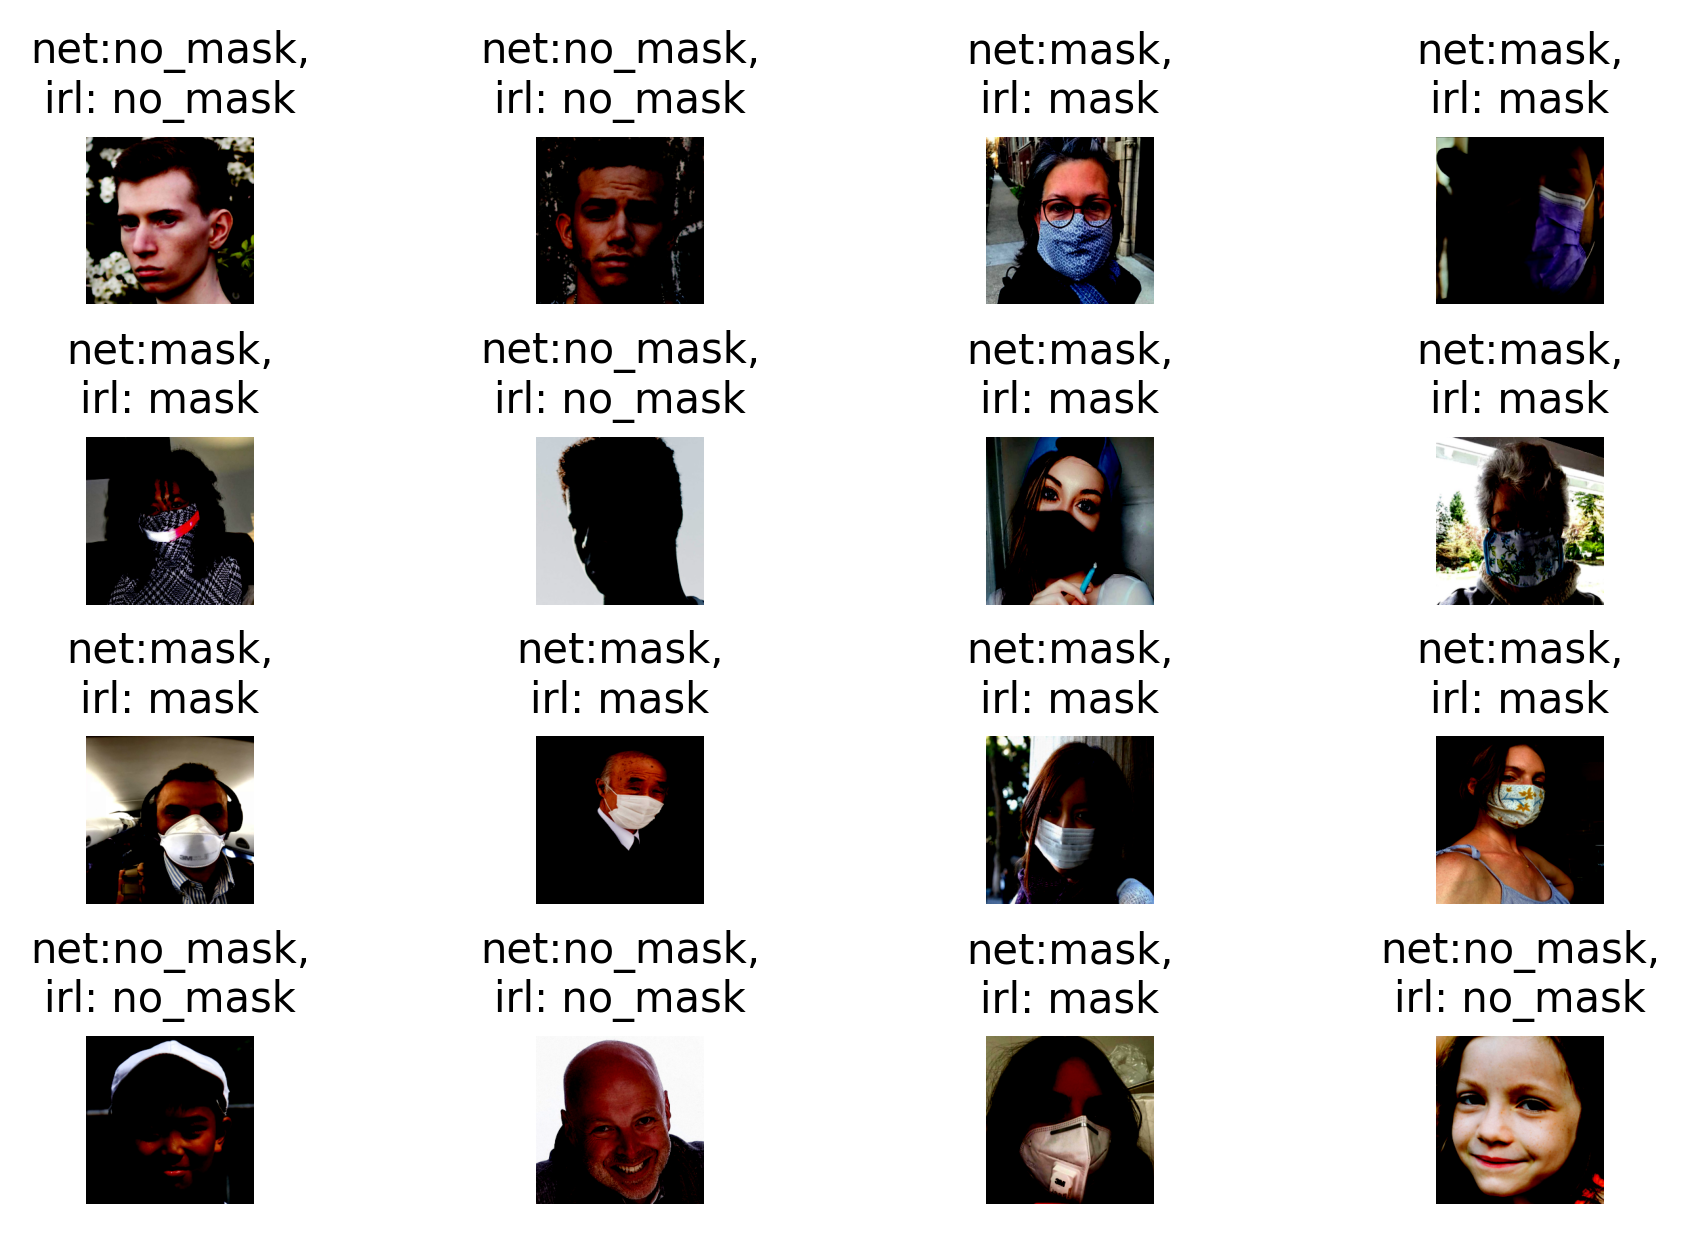

In [101]:
random_nums = [random.randint(0, len(validation_dataset) - 1) for _ in range(batch_size)]
imgs = [validation_dataset[i][0] for i in random_nums]
labls = [validation_dataset[i][1] for i in random_nums]

show_validation(imgs, labls)